In [1]:
import json
import  pickle
import joblib
import optuna
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy  as np
import pandas as pd
import tqdm
import time

from sklearn.cluster import KMeans
from eval_utils import *
from models_gaussian import GaussianDenseHMM, HMMLoggingMonitor, DenseHMMLoggingMonitor
from models_gaussian_A import GaussianDenseHMM as CoocHMM
from hmmlearn import hmm


2022-08-18 07:41:21.057335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 07:41:21.057397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
t = time.localtime()
RESULT_DIR = f'gaussian_dense_hmm_benchmark/eval-cooc-{t.tm_year}-{t.tm_mon}-{t.tm_mday}'

We have examined the efficiency of co-occurence based learning methods for Gaussian HMM. This notebook contains a comparison of:

- standard Gaussian Hidden Markov Model implementation,
- co-occurrence based larning for Gaussian Hidden Markov Model,
- EM learning for GaussianDenseHHMM,
- co-occurrence based learning for GaussianDenseHMM.

The dense representation was examined with fixed and tuned embedding length.

In [3]:
n = 8
s = 100
T = 1000
simple_model = True

In [4]:
l_fixed = True

RESULT_DIR = f'gaussian_dense_hmm_benchmark/eval-cooc-{t.tm_year}-{t.tm_mon}-{17}'
with open(f"{RESULT_DIR}/optuna_cooc_s{s}_T{T}_n{n}_simple_model{simple_model}_l{l_fixed}.pkl", "rb") as f:
    study = joblib.load(f)

In [5]:
study_res = pd.DataFrame([{**t.params, "mean": t.values[0], "std": t.values[1]} for t in study.trials])
study_res

,cooc_lr_param,cooc_epochs_param,mean,std
0,0.007055,95252,-1.029042e+08,4.989413e+07
1,0.000372,22013,-1.258788e+08,8.937642e+07
2,0.016005,14357,-6.724162e+07,1.405187e+07
3,0.315334,94224,-8.523348e+07,6.216957e+07
4,0.054786,15321,-8.100231e+07,1.229705e+07
5,0.001338,61685,-1.059174e+08,5.560698e+07
6,0.000292,54599,-6.600827e+07,9.538663e+06
7,0.070272,71114,-7.066690e+07,3.602548e+07
8,0.312263,43095,-7.776879e+07,1.773118e+07
9,0.000237,26975,-8.915181e+07,4.766469e+07


<AxesSubplot:xlabel='mean', ylabel='std'>

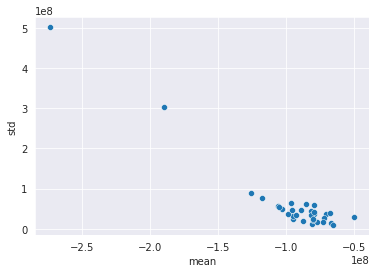

In [6]:
sns.scatterplot(data=study_res, x="mean", y="std")

In [30]:
best_params = dict()
best_params["cooc"] = study_res.sort_values("mean").iloc[-1, :2].to_dict()
best_params["cooc"]['cooc_epochs_param'] = int(best_params["cooc"]['cooc_epochs_param'])
best_params["cooc"]['l_param'] = int(np.ceil(n / 3))
best_params

{'cooc': {'cooc_lr_param': 0.060724553741338755,
  'cooc_epochs_param': 94151,
  'l_param': 3}}

In [8]:
best_result = {}
s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, _, em_scheduler = init_experiment((s, T, n), simple_model)
nodes = np.concatenate([np.array([-np.infty, Y_true.min()]),
                        (mu[1:] + mu[:-1]) / 2,
                        np.array([Y_true.max(), np.infty])])
m = nodes.shape[0] - 1

models = dict(cooc=CoocHMM, dense=GaussianDenseHMM, dense_em=GaussianDenseHMM)
monitors = dict(cooc=DenseHMMLoggingMonitor, dense=DenseHMMLoggingMonitor, dense_em=DenseHMMLoggingMonitor)
algs = dict(cooc="cooc", dense="cooc", dense_em="em")

## Tune hyper-parameters
l = np.ceil(n / 3) if l_fixed else None

In [9]:
lengths = np.array(lengths)

In [10]:
def _lengths_iterator(seqs, lengths):
    n_seqs = len(lengths)
    left, right = 0, 0

    for i in range(len(lengths)):
        right += lengths[i]
        yield seqs[left:right]
        left += lengths[i]

In [35]:
normal_cooc_prob(densehmm.means_.reshape(-1), densehmm.covars_.reshape(-1), nodes, A)[1:, 1:]

array([[0.00249859, 0.00148065, 0.001301  , 0.0019025 , 0.0223617 ,
        0.01847599, 0.00621811, 0.00385021, 0.00197173, 0.00464706],
       [0.00142556, 0.00111826, 0.00083279, 0.00080289, 0.01395968,
        0.00691197, 0.00475485, 0.00306707, 0.00149095, 0.0035148 ],
       [0.00141132, 0.00092005, 0.00075448, 0.00091582, 0.01088627,
        0.00754757, 0.00343824, 0.003244  , 0.00111296, 0.00261852],
       [0.00347152, 0.00204357, 0.00171855, 0.00206684, 0.00791379,
        0.00823772, 0.00249817, 0.01641233, 0.00107767, 0.00249278],
       [0.00720713, 0.00492176, 0.00516803, 0.01962201, 0.03583207,
        0.08725304, 0.02039976, 0.01771643, 0.01133188, 0.02831558],
       [0.02833943, 0.01776422, 0.01368818, 0.00899939, 0.07953052,
        0.03831641, 0.04410347, 0.0270325 , 0.00333408, 0.00391704],
       [0.00562601, 0.00282684, 0.00263223, 0.00380143, 0.0371787 ,
        0.03714907, 0.01453571, 0.00805659, 0.00186449, 0.00357255],
       [0.0058116 , 0.0036961 , 0.0030929

In [31]:
## Evaluate models

true_values = {
    "states": X_true,
    "transmat": A,
    "startprob": pi,
    "means": mu,
    "covars": sigma
}

# HMMlearn
best_result["HMMlearn"] = list()
wandb_params["init"].update({"job_type": f"n={n}-s={s}-T={s}-simple={simple_model}",
                             "name": f"HMMlearn"})
wandb_params["config"].update(dict(model="HMMlearn", m=0, l=0, lr=0,
                                   em_iter=em_iter(n), cooc_epochs=0,
                                   epochs=0), scheduler=False, simple_model=simple_model)
nodes_tmp = mu
nodes = np.concatenate([np.array([-np.infty, Y_true.min()]),
                        (nodes_tmp[1:] + nodes_tmp[:-1]).reshape(-1) / 2,
                        np.array([Y_true.max(), np.infty])])
Y_disc = (Y_true > nodes.reshape(1, -1)).sum(axis=-1).reshape(-1, 1)

for _ in range(10):
    hmm_monitor = HMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                    wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                    log_config={'metrics_after_convergence': True})
    hmm_model = hmm.GaussianHMM(n, n_iter=em_iter(n))
    hmm_model.monitor_ = hmm_monitor
    hmm_model.fit(Y_true, lengths)

    preds = hmm_model.predict(Y_true, lengths)
    perm = find_permutation(preds, X_true)

    best_result["HMMlearn"].append(
        {
            "time": time.perf_counter() - hmm_monitor._init_time,
            "logprob": hmm_model.score(Y_true, lengths),
            "acc": (X_true == np.array([perm[i] for i in preds])).mean(),
            "dtv_transmat": dtv(hmm_model.transmat_, A[perm, :][:, perm]),
            "dtv_startprob": dtv(hmm_model.startprob_, pi[perm]),
            "MAE_means": (abs(mu[perm] - hmm_model.means_[:, 0])).mean(),
            "MAE_sigma": (abs(sigma.reshape(-1)[perm] - hmm_model.covars_.reshape(-1))).mean(),
            "dtv_omega": dtv(empirical_cooc_prob(Y_disc, n, lengths),
                             normal_cooc_prob(hmm_model.means_.reshape(-1), hmm_model.covars_.reshape(-1), nodes, A))
        }
    )

# Custom models
for name in tqdm.tqdm(["cooc", "dense", "dense_em"],  desc="Model building"):
    model = models[name]
    monitor = monitors[name]
    alg = algs[name]
    params = best_params[name]
    best_result[name] = list()
    wandb_params["init"].update({"job_type": f"n={n}-s={s}-T={s}-simple={simple_model}",
                                 "name": f"name-l={params['l_param']}-lr={params['cooc_lr_param']}-epochs={params['cooc_epochs_param']}"})
    wandb_params["config"].update(dict(model="dense_cooc", m=0, l=int(params['l_param']), lr=params['cooc_lr_param'],
                                       em_iter=em_iter(n), cooc_epochs=params['cooc_epochs_param'],
                                       epochs=params['cooc_epochs_param']), scheduler=True,
                                  simple_model=simple_model)

    for _ in tqdm.tqdm(range(10), desc=f"Training {name}"):
        hmm_monitor = monitor(tol=TOLERANCE, n_iter=0, verbose=True,
                              wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                              log_config={'metrics_after_convergence': True})
        # kmeans = KMeans(n_clusters=n, random_state=0).fit(Y_true)
        densehmm = model(n, mstep_config={'cooc_epochs': params['cooc_epochs_param'],
                                          'cooc_lr': params['cooc_lr_param'],
                                          "l_uz": int(params['l_param']),
                                          'loss_type': 'square',
                                          'scheduler': em_scheduler},
                         covariance_type='diag', logging_monitor=hmm_monitor, nodes=nodes,
                         init_params="", params="stmc", early_stopping=False, opt_schemes={"cooc"},
                         discrete_observables=m)
        if alg == "cooc":
            densehmm.fit_coocs(Y_true, lengths)
        else:
            densehmm.fit(Y_true, lengths)

        preds = densehmm.predict(Y_true, lengths)
        perm = find_permutation(preds, X_true)

        best_result[name].append(
            {
                "time": time.perf_counter() - hmm_monitor._init_time,
                "logprob": densehmm.score(Y_true, lengths),
                "acc": (X_true == np.array([perm[i] for i in preds])).mean(),
                "dtv_transmat": dtv(densehmm.transmat_, A[perm, :][:, perm]),
                "dtv_startprob": dtv(densehmm.startprob_, pi[perm]),
                "MAE_means": (abs(mu[perm] - densehmm.means_[:, 0])).mean(),
                "MAE_sigma": (abs(sigma.reshape(-1)[perm] - densehmm.covars_.reshape(-1))).mean(),
                "dtv_omega": dtv(empirical_cooc_prob(Y_disc, n, lengths),
                                  normal_cooc_prob(densehmm.means_.reshape(-1), densehmm.covars_.reshape(-1), nodes, A))
            }
        )

with open(f"{RESULT_DIR}/best_result_s{s}_T{T}_n{n}_simple_model{simple_model}_l{l_fixed}.json", "w") as f:
    json.dump(best_result, f, indent=4)

Training cooc:   0%|                                     | 0/10 [00:00<?, ?it/s]

time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_log_prob,▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇█████████
time,29.94814
total_log_prob,-292834.6472


2022-08-18 08:02:29.424134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-18 08:02:29.424212: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-18 08:02:29.424257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-08-18 08:02:29.443902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 08:02:29.506086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization p

ValueError: operands could not be broadcast together with shapes (8,8) (11,11) 

In [ ]:
# Provide data
all_files = os.listdir(RESULT_DIR)

results = [s for s in all_files if len(s.split("_")) == 6]
studies = [s for s in all_files if len(s.split("_")) == 7]

cases = list(set(["_".join(s.split("_")[1:-1]) for s in studies]))

        27     -292834.6472          +0.0000


In [ ]:
# read all data
experiment = dict(studies  =dict(l_fixed=dict(),  l_tuned=dict()),
                  summaries=dict(l_fixed=dict(),  l_tuned=dict()))

In [ ]:
for c in cases:
    with open(f"{RESULT_DIR}/optuna_{c}_lTrue.pkl", "rb") as f:
        experiment["studies"]["l_fixed"][c] = joblib.load(f)
    with open(f"{RESULT_DIR}/optuna_{c}_lFalse.pkl", "rb") as f:
        experiment["studies"]["l_tuned"][c] = joblib.load(f)
    with open(f"{RESULT_DIR}/best_result_{c}_lTrue.json", "r") as f:
        experiment["summaries"]["l_fixed"][c] = json.load(f)
    with open(f"{RESULT_DIR}/best_result_{c}_lFalse.json", "r") as f:
        experiment["summaries"]["l_tuned"][c] = json.load(f)

## Compare tunning methods

In [16]:
# Variable importance
for c in cases:
    display(optuna.visualization.plot_param_importances(experiment["studies"]["l_fixed"][c],
                                                        target=lambda t: t.values[0], target_name="flops",  title="Fixed"))
    display(optuna.visualization.plot_param_importances(experiment["studies"]["l_tuned"][c],
                                                        target=lambda t: t.values[0], target_name="flops", title="Tuned"))

In [40]:
# l zafixowane versus wyniki hiperparametryzacji zależnie od l
for c in cases:
    no_trials = len(experiment["studies"]["l_fixed"][c].trials)
    x = [experiment["studies"]["l_fixed"][c].trials[i].params['l_param'] for i in range(no_trials)]
    y = [experiment["studies"]["l_fixed"][c].trials[i].values[0] for i in range(no_trials)]
    name = cases.split("_")[0]
    sns.violinplot(x, y)
    plt.xlabel("l")
    plt.ylabel("log-likelihood")
    plt.title(f"{name} (when fixed l={int(np.ceil(8 / 3))})")
    plt.show()

In [17]:
# s, T, n, simple_model = 100, 40, 4, True
#
# with open(f"gaussian_dense_hmm_benchmark/fit_coocs_ll_mini-2022-8-12/optuna_s{s}_T{T}_n{n}_simple_model{simple_model}.pkl",  "rb") as f:
#     study = joblib.load(f)

## Compare  results of all methods

In [46]:
# with open(f"gaussian_dense_hmm_benchmark/fit_coocs_ll_mini-2022-8-12/best_result_s{s}_T{T}_n{n}_simple_model{simple_model}.json",  "r") as f:
#     best_results = json.load(f)

In [48]:
#  tabularise results
for c in cases:
    display(f'\n\n### {" ".join(c.split("_"))}')
    display(pd.DataFrame(experiment["summaries"]["l_fixed"][c]).style.set_caption("l fixed"))
    display(pd.DataFrame(experiment["summaries"]["l_tuned"][c]).style.set_caption("l tuned"))


## Train co-oc + EM

In [3]:
# Use the same parameters and provide time benchmarks

In [ ]:
s, T, n, pi, A, mu, sigma, result, true_values, wandb_params, X_true, Y_true, lengths, data, em_scheduler = init_experiment(dsize=(100, 100, 8), simple_model=True)


def to_discrete(X, m):
    kmeans = KMeans(n_clusters=m, random_state=0).fit(Y_true)
    nodes_tmp = np.sort(kmeans.cluster_centers_, axis=0)
    nodes = np.concatenate([(nodes_tmp[1:] + nodes_tmp[:-1]) / 2, np.array([[np.infty]])])
    return (X > nodes.reshape(1, -1)).sum(axis=-1).reshape(-1, 1), nodes.reshape(-1)


Y_disc, nodes = to_discrete(Y_true, m=n)

In [ ]:
for  _  in range(10):
    # TODO: read parameters from dense cooc and dense em
    cooc_params = experiment["studies"]["l_fixed"][c].best_params  # TODO: c
    em_params   = experiment["studies"]["l_fixed"][c].best_params  # TODO: c
    mstep_cofig = {"cooc_lr": cooc_params['cooc_lr_param'],
                   "cooc_epochs": cooc_params['cooc_epochs_param'],
                   "l_uz": cooc_params['l_param'],
                   "em_params":  em_params['cooc_lr_param'],
                   "em_epochs": em_params['cooc_epochs_param'],
                   "loss_type": 'square',
                   "scheduler": em_scheduler}
    wandb_params["init"].update({"name": f"dense-cooc+em"})
    hmm_monitor = HMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                    wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                    log_config={'metrics_after_convergence': True})
    densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                                covariance_type='diag', opt_schemes={"cooc"},
                                nodes=np.concatenate([np.array([-np.infty]), nodes]),
                                discrete_observables=n, em_iter=20,
                                logging_monitor=hmm_monitor,
                                init_params="", params="stmc", early_stopping=True)
    densehmm.means_ = mu.reshape(-1, 1)
    start = time.perf_counter()
    densehmm.fit_coocs(Y_true, lengths)
    densehmm.fit(Y_true, lengths)
    time_tmp = time.perf_counter() - start

#  Results in wanbd